In [1]:
import numpy
import matplotlib.pyplot as plt
import pandas as pd
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
%matplotlib inline  


/Users/chronowanderer/anaconda3/envs/tensorflow/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
TIME_STEPS = 8
HIDDEN_UNITS = 32
INPUT_UNITS = 2
OUTPUT_UNITS = 2
BATCH_SIZE = 64
TRAIN_SIZE = 100
EFFECTIVE_COEFFICIENT = 0.25
EFFECTIVE_LOC = int(TRAIN_SIZE / EFFECTIVE_COEFFICIENT)
EPOCH = 10
look_back = TIME_STEPS


In [3]:
def atan_positive(x, y):
    if (x > 0) & (y > 0):
        theta = math.atan(y / x)
    elif (x == 0) & (y > 0):
        theta = math.pi / 2
    elif (x < 0):
        theta = math.pi + math.atan(y / x)
    elif (x == 0) & (y < 0):
        theta = 3 * math.pi / 2
    elif (x > 0) & (y <= 0):
        theta = 2 * math.pi + math.atan(y / x)
    return theta

def oup2(mu1, mu2, a, sigma, tau, h, lentmax):
    locRT = 0
    theta_T = 999
    x = tau * mu1 * h + sigma * numpy.random.randn(lentmax) * math.sqrt(h)
    y = tau * mu2 * h + sigma * numpy.random.randn(lentmax) * math.sqrt(h)
    a_r = a - math.sqrt(h) * sigma / 2.0
    x_start = 0.0
    y_start = 0.0
    w = [x_start]
    z = [y_start] 
    flag = 0
    for k in numpy.arange(1, lentmax):
        w.append(w[k - 1] + x[k] - tau * w[k - 1] * h)
        z.append(z[k - 1] + y[k] - tau * z[k - 1] * h)
        if (flag == 0) & (w[k] ** 2 + z[k] ** 2 >= a_r ** 2):
            locRT = k
            theta_T = atan_positive(w[k], z[k]) / 2.0
            flag = 1
    return (w, z, theta_T, locRT)


In [4]:
def semicircular_error(r, t):
    e = r - t
    if e >= 90:
        e = e - 180
    elif e < -90:
        e = e + 180
    return e


In [5]:
norm = 1.0
a = 1.0
sigma = 1.0
tau = 1.0
RESP = 60

numSeries = 500 # training & testing & sequently predicting
numPredict = 100 # complete prediction
tmax = 3.0
h = 0.001
lentmax = int(tmax / h)
T = numpy.linspace(0, tmax, lentmax, endpoint = False)
DATA_i = 0
DATA_f = lentmax - 1
Response, Error, RTloc = [], [], []
Dat = []

mu1 = norm * math.cos(2 * RESP * math.pi / 180)
mu2 = norm * math.sin(2 * RESP * math.pi / 180)

i = 0
while i < (numSeries + numPredict):
    (L_x, L_y, theta, t_loc) = oup2(mu1, mu2, a, sigma, tau, h, lentmax)
    if t_loc >= EFFECTIVE_LOC:
        Response.append(theta / math.pi * 180)
        Error.append(semicircular_error(theta / math.pi * 180, RESP))
        RTloc.append(t_loc)
        temp = []
        for j in numpy.arange(lentmax):
            temp.append([L_x[j], L_y[j]])
        Dat.append(temp)
        i = i + 1
RTloc = numpy.array(RTloc)

Dat = numpy.array(Dat) # all data
Data = Dat[0 : numSeries, :, :] # training & testing & sequently predicting
Data_p = Dat[numSeries : numSeries + numPredict, :, :] # complete prediction

dataset, dataset_t = [], []
for i in numpy.arange(numSeries):
    for j in numpy.arange(lentmax):
        dataset.append(Data[i, j])
        dataset_t.append(Data[i, j])
dataset = numpy.array(dataset)
dataset_p = []
for i in numpy.arange(numPredict):
    for j in numpy.arange(lentmax):
        dataset_p.append(Data_p[i, j])
        dataset_t.append(Data_p[i, j])
predict = numpy.array(dataset_p)
dataset_t = numpy.array(dataset_t)

print dataset.shape, predict.shape, dataset_t.shape


(1500000, 2) (300000, 2) (1800000, 2)


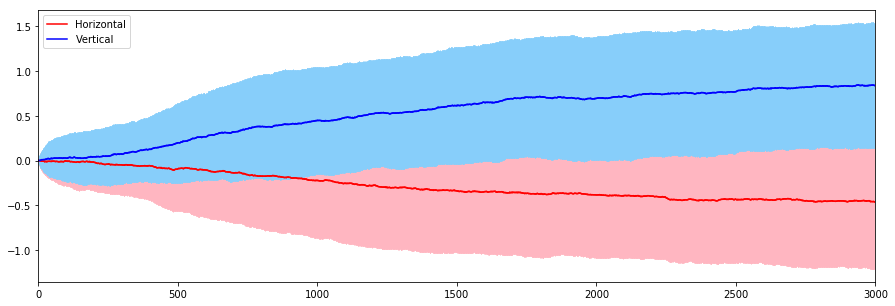

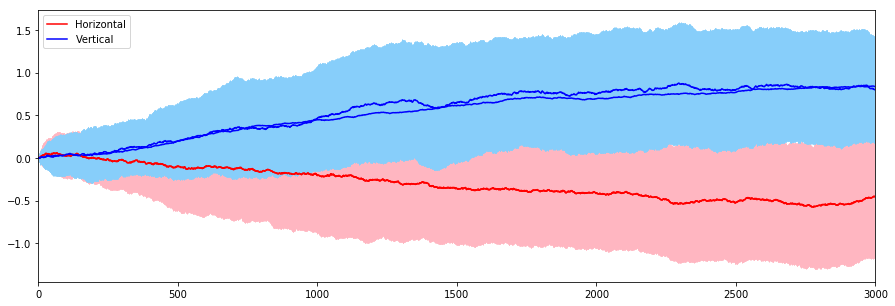

In [6]:
dataset_mean = numpy.mean(Data, axis = 0)

# including SD bars
dataset_x_mean = numpy.mean(Data[:,:,0], axis = 0)
dataset_x_bar = numpy.std(Data[:,:,0], axis = 0)
dataset_y_mean = numpy.mean(Data[:,:,1], axis = 0)
dataset_y_bar = numpy.std(Data[:,:,1], axis = 0)

plt.figure(figsize=(15, 5))
plt.xlim(0, lentmax)
x_lines = plt.plot(dataset_x_mean, label="Horizontal", color="r")
plt.errorbar(numpy.arange(lentmax), dataset_x_mean, yerr = dataset_x_bar, color='r', ecolor='lightpink', elinewidth = 1, capsize = 0)
y_lines = plt.plot(dataset_y_mean, label="Vertical", color="b")
plt.errorbar(numpy.arange(lentmax), dataset_y_mean, yerr = dataset_y_bar, color='b', ecolor='lightskyblue', elinewidth = 1, capsize = 0)
plt.legend(handles = [x_lines[0], y_lines[0]], loc="upper left")
plt.show()

dataset_p_mean = numpy.mean(Data_p, axis = 0)

# including SD bars
dataset_p_x_mean = numpy.mean(Data_p[:,:,0], axis = 0)
dataset_p_x_bar = numpy.std(Data_p[:,:,0], axis = 0)
dataset_p_y_mean = numpy.mean(Data_p[:,:,1], axis = 0)
dataset_p_y_bar = numpy.std(Data_p[:,:,1], axis = 0)

plt.figure(figsize=(15, 5))
plt.xlim(0, lentmax)
x_p_lines = plt.plot(dataset_p_x_mean, label="Horizontal", color="r")
plt.errorbar(numpy.arange(lentmax), dataset_p_x_mean, yerr = dataset_p_x_bar, color='r', ecolor='lightpink', elinewidth = 1, capsize = 0)
y_p_lines = plt.plot(dataset_y_mean, label="Vertical", color="b")
plt.errorbar(numpy.arange(lentmax), dataset_p_y_mean, yerr = dataset_p_y_bar, color='b', ecolor='lightskyblue', elinewidth = 1, capsize = 0)
plt.legend(handles = [x_p_lines[0], y_p_lines[0]], loc="upper left")
plt.show()


In [7]:
# convert an array of values into a dataset matrix
def create_dataset(series, size, dataset, look_back):
    dataX, dataY = [], []
    for k in range(series):
        kk = k * size
        for i in range(size - look_back):
            a = dataset[(kk+i) : (kk+i+look_back), :]
            dataX.append(a)
            dataY.append(dataset[kk+i+look_back, :])
    return numpy.array(dataX), numpy.array(dataY)


In [8]:
TOTAL_TIME = Data.shape[1]

# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset_t = scaler.fit_transform(dataset_t)
dataset = dataset_t[0:numSeries*lentmax, :]
predict = dataset_t[numSeries*lentmax:(numSeries+numPredict)*lentmax, :]

# split into train and test sets
train_size = TRAIN_SIZE
test_size = TOTAL_TIME - train_size + look_back
train, test = [], []
for k in range(numSeries):
    kk = k * TOTAL_TIME
    for t in range(kk, kk+train_size):
        train.append(dataset[t, :])
    for t in range(kk+train_size-look_back, kk+TOTAL_TIME):
        test.append(dataset[t, :])
train = numpy.array(train)
test = numpy.array(test)
        
print train.shape, test.shape, predict.shape

# use this function to prepare the train and test datasets for modeling
trainX, trainY = create_dataset(numSeries, train_size, train, look_back)
testX, testY = create_dataset(numSeries, test_size, test, look_back)
predictX, predictY = create_dataset(numPredict, TOTAL_TIME, predict, look_back)

# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], look_back, trainX.shape[2]))
testX = numpy.reshape(testX, (testX.shape[0], look_back, testX.shape[2]))
predictX = numpy.reshape(predictX, (predictX.shape[0], look_back, predictX.shape[2]))

print trainX.shape, trainY.shape
print testX.shape, testY.shape
print predictX.shape, predictY.shape


(50000, 2) (1454000, 2) (300000, 2)
(46000, 8, 2) (46000, 2)
(1450000, 8, 2) (1450000, 2)
(299200, 8, 2) (299200, 2)


In [9]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(HIDDEN_UNITS, input_shape=(look_back, INPUT_UNITS)))
model.add(Dense(OUTPUT_UNITS))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs = EPOCH, batch_size = BATCH_SIZE, verbose = 2)


Epoch 1/10
 - 5s - loss: 0.0042
Epoch 2/10
 - 5s - loss: 1.2940e-04
Epoch 3/10
 - 5s - loss: 1.1279e-04
Epoch 4/10
 - 6s - loss: 1.0375e-04
Epoch 5/10
 - 6s - loss: 9.5360e-05
Epoch 6/10
 - 6s - loss: 8.7917e-05
Epoch 7/10
 - 6s - loss: 8.0434e-05
Epoch 8/10
 - 6s - loss: 7.2701e-05
Epoch 9/10
 - 6s - loss: 6.6212e-05
Epoch 10/10
 - 6s - loss: 6.1130e-05


In [10]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
predictPredict = model.predict(predictX)

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform(trainY)
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(testY)
predictPredict = scaler.inverse_transform(predictPredict)
predictY = scaler.inverse_transform(predictY)

trainScore = math.sqrt(mean_squared_error(trainY, trainPredict))
print('Train Score: %.4f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY, testPredict))
print('Test Score: %.4f RMSE' % (testScore))
predictScore = math.sqrt(mean_squared_error(predictY, predictPredict))
print('Prediction Score: %.4f RMSE' % (predictScore))


Train Score: 0.0446 RMSE
Test Score: 0.0525 RMSE
Prediction Score: 0.0526 RMSE


In [11]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(Data[0])
trainPredictPlot[:, :] = numpy.nan
trainPredictBar = numpy.empty_like(Data[0])
trainPredictBar[:, :] = numpy.nan
for t in range(train_size - look_back):
    temp = []
    for s in range(numSeries):
        temp.append(trainPredict[t + s * (TRAIN_SIZE - look_back), :])
    temp = numpy.array(temp)
    trainPredictPlot[t + look_back, :] = numpy.mean(temp, axis = 0)
    trainPredictBar[t + look_back, :] = numpy.std(temp, axis = 0)

# shift test predictions for plotting
testPredictPlot = numpy.empty_like(Data[0])
testPredictPlot[:, :] = numpy.nan
testPredictBar = numpy.empty_like(Data[0])
testPredictBar[:, :] = numpy.nan
for t in range(TOTAL_TIME - train_size):
    temp = []
    for s in range(numSeries):
        temp.append(testPredict[t + s * (TOTAL_TIME - train_size), :])
    temp = numpy.array(temp)
    testPredictPlot[t + train_size, :] = numpy.mean(temp, axis = 0)
    testPredictBar[t + train_size, :] = numpy.std(temp, axis = 0)

# shift complete predictions for plotting
predictPredictPlot = numpy.empty_like(Data_p[0])
predictPredictPlot[:, :] = numpy.nan
predictPredictBar = numpy.empty_like(Data_p[0])
predictPredictBar[:, :] = numpy.nan
for t in range(TOTAL_TIME - look_back):
    temp = []
    for s in range(numPredict):
        temp.append(predictPredict[t + s * (TOTAL_TIME - look_back), :])
    temp = numpy.array(temp)
    predictPredictPlot[t + look_back, :] = numpy.mean(temp, axis = 0)
    predictPredictBar[t + look_back, :] = numpy.std(temp, axis = 0)   
        

In [12]:
# Output the estimated response
a_r = a - math.sqrt(h) * sigma / 2.0
Estimated_locRT = 0
Estimated_theta = 999
for k in numpy.arange(lentmax):
    if (trainPredictPlot[k,1] ** 2 + trainPredictPlot[k,0] ** 2 >= a_r ** 2):
        Estimated_locRT = k
        temp = trainPredictPlot[k,:]
        Estimated_theta = atan_positive(temp[0], temp[1]) / 2.0
        break
    elif (testPredictPlot[k,1] ** 2 + testPredictPlot[k,0] ** 2 >= a_r ** 2):
        Estimated_locRT = k
        temp = testPredictPlot[k,:]
        Estimated_theta = atan_positive(temp[0], temp[1]) / 2.0
        break
Estimated_theta = Estimated_theta / math.pi * 180

Predicted_locRT = 0
Predicted_theta = 999
for k in numpy.arange(lentmax):
    if (predictPredictPlot[k,1] ** 2 + predictPredictPlot[k,0] ** 2 >= a_r ** 2):
        Predicted_locRT = k
        temp = predictPredictPlot[k,:]
        Predicted_theta = atan_positive(temp[0], temp[1]) / 2.0
        break
Predicted_theta = Predicted_theta / math.pi * 180

print('Estimated Response: %.4f degs' % (Estimated_theta))
print('Estimated Reaction Time: %d ms' % (int(Estimated_locRT * h * 1000)))
print('Drift Direction: %.4f degs' % (RESP))
print('Mean Reaction Time: %d ms' % (int(numpy.mean(RTloc[0:numSeries]) * h * 1000)))

print('Predicted Response: %.4f degs' % (Predicted_theta))
print('Predicted Reaction Time: %d ms' % (int(Predicted_locRT * h * 1000)))
print('Drift Direction: %.4f degs' % (RESP))
print('Mean Reaction Time: %d ms' % (int(numpy.mean(RTloc[numSeries:numSeries+numPredict]) * h * 1000)))


Estimated Response: 57238.4837 degs
Estimated Reaction Time: 0 ms
Drift Direction: 60.0000 degs
Mean Reaction Time: 792 ms
Predicted Response: 59.8843 degs
Predicted Reaction Time: 2292 ms
Drift Direction: 60.0000 degs
Mean Reaction Time: 772 ms


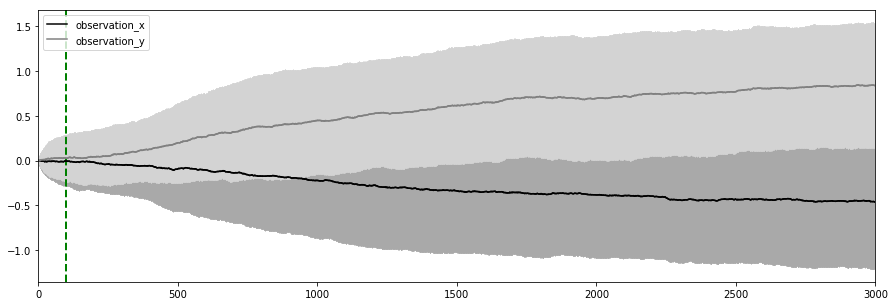

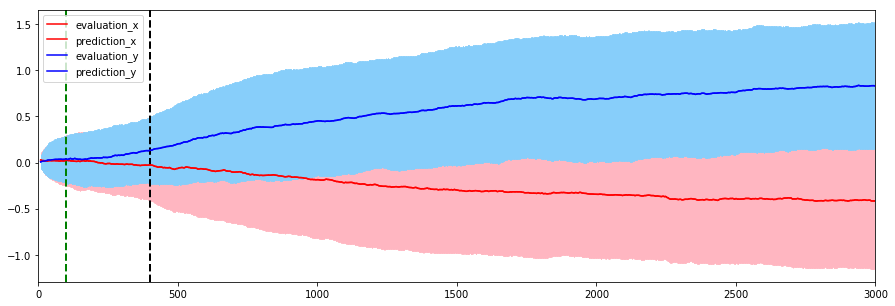

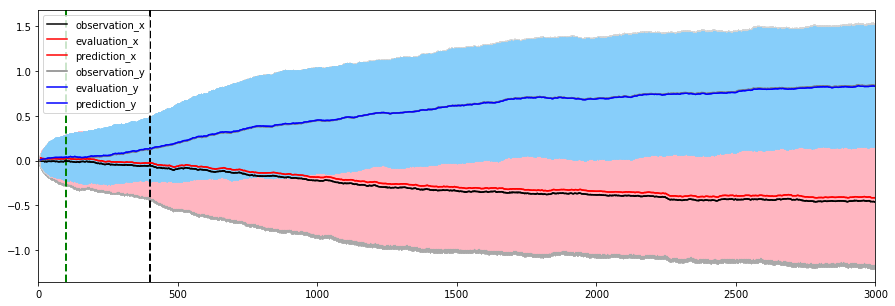

In [13]:
# plot baseline and estimations
plt.figure(figsize=(15, 5))
plt.xlim(DATA_i, TOTAL_TIME)
plt.axvline(train_size - 1, linestyle="dashed", linewidth = 2, color='g')
observed_x = plt.plot(dataset_x_mean, label="observation_x", color="k")
plt.errorbar(numpy.arange(lentmax), dataset_x_mean, yerr = dataset_x_bar, color='k', ecolor='darkgrey', elinewidth = 1, capsize = 0)
observed_y = plt.plot(dataset_y_mean, label="observation_y", color="gray")
plt.errorbar(numpy.arange(lentmax), dataset_y_mean, yerr = dataset_y_bar, color='grey', ecolor='lightgrey', elinewidth = 1, capsize = 0)
plt.legend(handles=[observed_x[0], observed_y[0]],loc="upper left")
plt.show()

plt.figure(figsize=(15, 5))
plt.xlim(DATA_i, TOTAL_TIME)
plt.axvline(train_size - 1, linestyle="dashed", linewidth = 2, color='g')
plt.axvline(EFFECTIVE_LOC, linestyle="dashed", linewidth = 2, color='k')
evaluated_x = plt.plot(trainPredictPlot[:,0], label="evaluation_x", color="r")
plt.errorbar(numpy.arange(lentmax), trainPredictPlot[:,0], yerr=trainPredictBar[:,0], color='r', ecolor='lightpink', elinewidth = 1, capsize = 0)
evaluated_y = plt.plot(trainPredictPlot[:,1], label="evaluation_y", color="b")
plt.errorbar(numpy.arange(lentmax), trainPredictPlot[:,1], yerr=trainPredictBar[:,1], color='b', ecolor='lightskyblue', elinewidth = 1, capsize = 0)
predicted_x = plt.plot(testPredictPlot[:,0], label="prediction_x", color="r")
plt.errorbar(numpy.arange(lentmax), testPredictPlot[:,0], yerr=testPredictBar[:,0], color='r', ecolor='lightpink', elinewidth = 1, capsize = 0)
predicted_y  = plt.plot(testPredictPlot[:,1], label="prediction_y", color="b")
plt.errorbar(numpy.arange(lentmax), testPredictPlot[:,1], yerr=testPredictBar[:,1], color='b', ecolor='lightskyblue', elinewidth = 1, capsize = 0)
plt.legend(handles=[evaluated_x[0], predicted_x[0], evaluated_y[0], predicted_y[0]],loc="upper left")
plt.show()

plt.figure(figsize=(15, 5))
plt.xlim(DATA_i, TOTAL_TIME)
plt.axvline(train_size - 1, linestyle="dashed", linewidth = 2, color='g')
plt.axvline(EFFECTIVE_LOC, linestyle="dashed", linewidth = 2, color='k')
observed_x = plt.plot(dataset_x_mean, label="observation_x", color="k")
plt.errorbar(numpy.arange(lentmax), dataset_x_mean, yerr = dataset_x_bar, color='k', ecolor='darkgrey', elinewidth = 1, capsize = 0)
observed_y = plt.plot(dataset_y_mean, label="observation_y", color="gray")
plt.errorbar(numpy.arange(lentmax), dataset_y_mean, yerr = dataset_y_bar, color='grey', ecolor='lightgrey', elinewidth = 1, capsize = 0)
plt.legend(handles=[],loc="upper left")
evaluated_x = plt.plot(trainPredictPlot[:,0], label="evaluation_x", color="r")
plt.errorbar(numpy.arange(lentmax), trainPredictPlot[:,0], yerr=trainPredictBar[:,0], color='r', ecolor='lightpink', elinewidth = 1, capsize = 0)
evaluated_y = plt.plot(trainPredictPlot[:,1], label="evaluation_y", color="b")
plt.errorbar(numpy.arange(lentmax), trainPredictPlot[:,1], yerr=trainPredictBar[:,1], color='b', ecolor='lightskyblue', elinewidth = 1, capsize = 0)
predicted_x = plt.plot(testPredictPlot[:,0], label="prediction_x", color="r")
plt.errorbar(numpy.arange(lentmax), testPredictPlot[:,0], yerr=testPredictBar[:,0], color='r', ecolor='lightpink', elinewidth = 1, capsize = 0)
predicted_y  = plt.plot(testPredictPlot[:,1], label="prediction_y", color="b")
plt.errorbar(numpy.arange(lentmax), testPredictPlot[:,1], yerr=testPredictBar[:,1], color='b', ecolor='lightskyblue', elinewidth = 1, capsize = 0)
plt.legend(handles=[observed_x[0], evaluated_x[0], predicted_x[0], observed_y[0], evaluated_y[0], predicted_y[0]],loc="upper left")
plt.show()

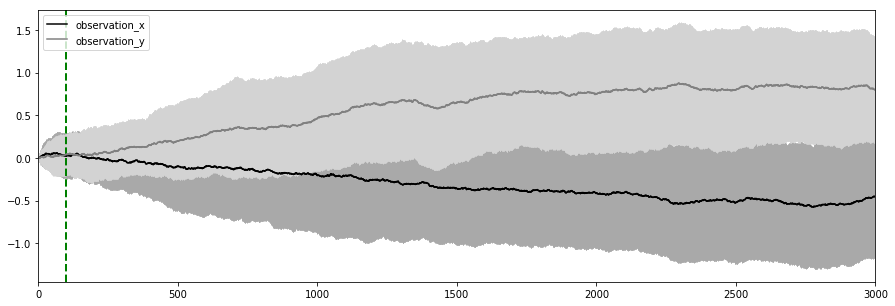

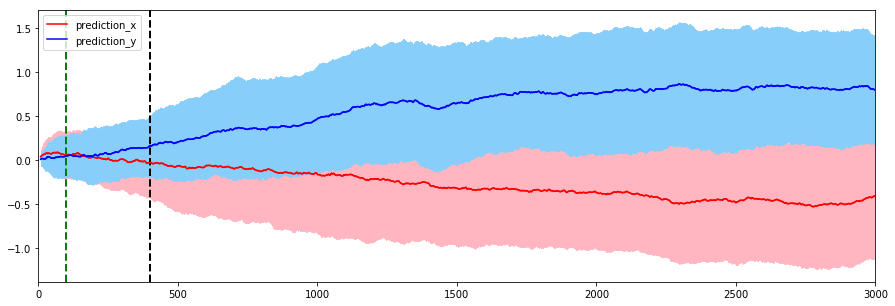

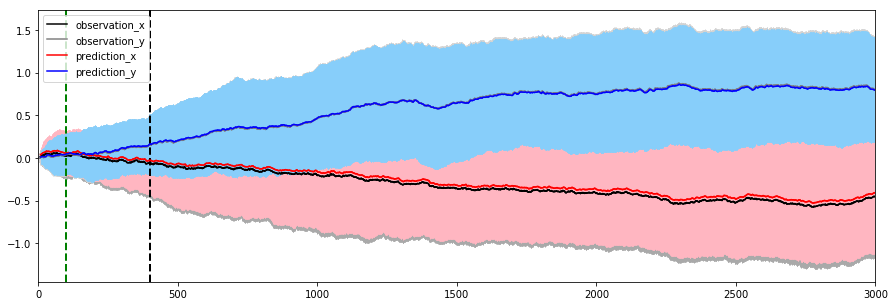

In [14]:
# plot complete predictions
plt.figure(figsize=(15, 5))
plt.xlim(DATA_i, TOTAL_TIME)
plt.axvline(train_size - 1, linestyle="dashed", linewidth = 2, color='g')
observed_x = plt.plot(dataset_p_x_mean, label="observation_x", color="k")
plt.errorbar(numpy.arange(lentmax), dataset_p_x_mean, yerr = dataset_p_x_bar, color='k', ecolor='darkgrey', elinewidth = 1, capsize = 0)
observed_y = plt.plot(dataset_p_y_mean, label="observation_y", color="gray")
plt.errorbar(numpy.arange(lentmax), dataset_p_y_mean, yerr = dataset_p_y_bar, color='grey', ecolor='lightgrey', elinewidth = 1, capsize = 0)
plt.legend(handles=[observed_x[0], observed_y[0]],loc="upper left")
plt.show()

plt.figure(figsize=(15, 5))
plt.xlim(DATA_i, TOTAL_TIME)
plt.axvline(train_size - 1, linestyle="dashed", linewidth = 2, color='g')
plt.axvline(EFFECTIVE_LOC, linestyle="dashed", linewidth = 2, color='k')
predicted_x = plt.plot(predictPredictPlot[:,0], label="prediction_x", color="r")
plt.errorbar(numpy.arange(lentmax), predictPredictPlot[:,0], yerr=predictPredictBar[:,0], color='r', ecolor='lightpink', elinewidth = 1, capsize = 0)
predicted_y  = plt.plot(predictPredictPlot[:,1], label="prediction_y", color="b")
plt.errorbar(numpy.arange(lentmax), predictPredictPlot[:,1], yerr=predictPredictBar[:,1], color='b', ecolor='lightskyblue', elinewidth = 1, capsize = 0)
plt.legend(handles=[predicted_x[0], predicted_y[0]],loc="upper left")
plt.show()

plt.figure(figsize=(15, 5))
plt.xlim(DATA_i, TOTAL_TIME)
plt.axvline(train_size - 1, linestyle="dashed", linewidth = 2, color='g')
plt.axvline(EFFECTIVE_LOC, linestyle="dashed", linewidth = 2, color='k')
observed_x = plt.plot(dataset_p_x_mean, label="observation_x", color="k")
plt.errorbar(numpy.arange(lentmax), dataset_p_x_mean, yerr = dataset_p_x_bar, color='k', ecolor='darkgrey', elinewidth = 1, capsize = 0)
observed_y = plt.plot(dataset_p_y_mean, label="observation_y", color="gray")
plt.errorbar(numpy.arange(lentmax), dataset_p_y_mean, yerr = dataset_p_y_bar, color='grey', ecolor='lightgrey', elinewidth = 1, capsize = 0)
predicted_x = plt.plot(predictPredictPlot[:,0], label="prediction_x", color="r")
plt.errorbar(numpy.arange(lentmax), predictPredictPlot[:,0], yerr=predictPredictBar[:,0], color='r', ecolor='lightpink', elinewidth = 1, capsize = 0)
predicted_y  = plt.plot(predictPredictPlot[:,1], label="prediction_y", color="b")
plt.errorbar(numpy.arange(lentmax), predictPredictPlot[:,1], yerr=predictPredictBar[:,1], color='b', ecolor='lightskyblue', elinewidth = 1, capsize = 0)
plt.legend(handles=[observed_x[0], observed_y[0], predicted_x[0], predicted_y[0]],loc="upper left")
plt.show()


In [15]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(Data)
trainPredictPlot[:, :, :] = numpy.nan
for s in range(numSeries):
    for t in range(train_size - look_back):
        trainPredictPlot[s, t + look_back, :] = trainPredict[t + s * (TRAIN_SIZE - look_back), :]

# shift test predictions for plotting
testPredictPlot = numpy.empty_like(Data)
testPredictPlot[:, :, :] = numpy.nan
for s in range(numSeries):
    for t in range(TOTAL_TIME - train_size):
        testPredictPlot[s, t + train_size, :] = testPredict[t + s * (TOTAL_TIME - train_size), :]

# shift complete predictions for plotting
predictPredictPlot = numpy.empty_like(Data_p)
predictPredictPlot[:, :, :] = numpy.nan
for s in range(numPredict):
    for t in range(TOTAL_TIME - look_back):
        predictPredictPlot[s, t + look_back, :] = predictPredict[t + s * (TOTAL_TIME - look_back), :]


In [16]:
# Output the estimation score
Observed_theta, Observed_error, Observed_locRT = [], [], []
Estimated_theta, Estimated_error, Estimated_locRT = [], [], []
for s in range(numSeries):
    a_r = a - math.sqrt(h) * sigma / 2.0
    for k in range(lentmax):
        temp = trainPredictPlot[s, k, :]
        if (temp[0] ** 2 + temp[1] ** 2 >= a_r ** 2):
            Observed_locRT.append(RTloc[s])
            Estimated_locRT.append(k)
            Observed_theta.append(Response[s])
            tt = atan_positive(temp[0], temp[1]) / 2.0 / math.pi * 180
            Estimated_theta.append(tt)
            Observed_error.append(Error[s])
            Estimated_error.append(semicircular_error(tt, RESP))
            break
        temp = testPredictPlot[s, k, :]
        if (temp[0] ** 2 + temp[1] ** 2 >= a_r ** 2):
            Observed_locRT.append(RTloc[s])
            Estimated_locRT.append(k)
            Observed_theta.append(Response[s])
            tt = atan_positive(temp[0], temp[1]) / 2.0 / math.pi * 180
            Estimated_theta.append(tt)
            Observed_error.append(Error[s])
            Estimated_error.append(semicircular_error(tt, RESP))
            break
print len(Observed_error)

Res0 = [i * math.pi / 180 for i in Observed_error]
Res = [i * math.pi / 180 for i in Estimated_error]
Err = Res
for i in range((len(Observed_error))):
    Err[i] = (semicircular_error(Estimated_error[i], Observed_error[i]) * math.pi / 180) ** 2
ResponsePredictionScore = math.sqrt(sum(Err) / len(Err))
RT0 = [i * h for i in Observed_locRT]
RT = [i * h for i in Estimated_locRT]
RTPredictionScore = math.sqrt(mean_squared_error(RT0, RT))
            
print('Error Estimation Score: %.4f RMSE' % (ResponsePredictionScore))
print('RT Estimation Score: %.4f RMSE' % (RTPredictionScore))


500
Error Estimation Score: 0.1813 RMSE
RT Estimation Score: 0.2019 RMSE


R^2 score for regression on Error: 0.8341
k = 0.9218


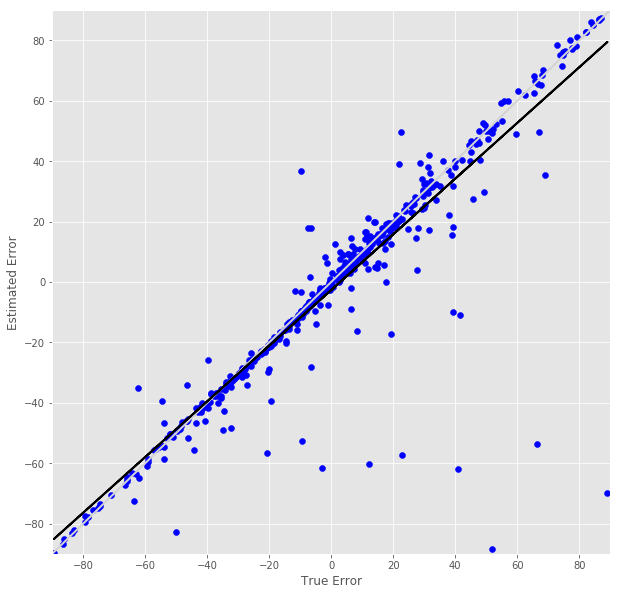

R^2 score for regression on RT: 0.7766
k = 0.9702


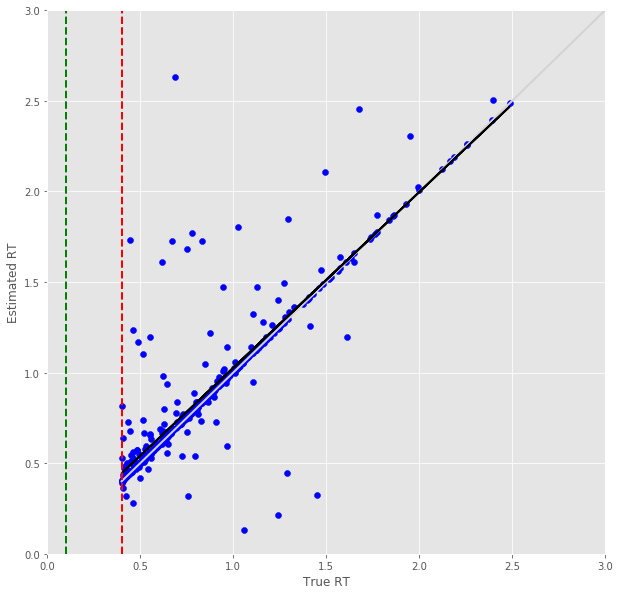

In [17]:
# plot Response Error and Reaction Time
plt.figure(figsize=(10, 10))
plt.style.use('ggplot')
plt.xlim(-90, 90)
plt.ylim(-90, 90)
plt.scatter(Observed_error, Estimated_error, color = 'b')
plt.xlabel("True Error")  
plt.ylabel("Estimated Error")
xx = numpy.linspace(-90, 90, 1000)
yy = xx
plt.plot(xx, yy, linewidth = 2, color = 'lightgrey')
Observed_error = numpy.array(Observed_error)
reg = LinearRegression().fit(Observed_error.reshape(-1, 1), Estimated_error)
print('R^2 score for regression on Error: %.4f' % (reg.score(Observed_error.reshape(-1, 1), Estimated_error)))
print('k = %.4f' % (reg.coef_))
pred = reg.predict(Observed_error.reshape(-1, 1))
plt.plot(Observed_error, pred, linewidth = 2, color = 'k')
plt.show()

plt.figure(figsize=(10, 10))
plt.style.use('ggplot')
plt.xlim(0, tmax)
plt.ylim(0, tmax)
plt.scatter(RT0, RT, color = 'b')
plt.xlabel("True RT")  
plt.ylabel("Estimated RT")
xx = numpy.linspace(EFFECTIVE_LOC * h, tmax, 1000)
yy = xx
plt.plot(xx, yy, linewidth = 2, color = 'lightgrey')
RT0 = numpy.array(RT0)
reg = LinearRegression().fit(RT0.reshape(-1, 1), RT)
print('R^2 score for regression on RT: %.4f' % (reg.score(RT0.reshape(-1, 1), RT)))
print('k = %.4f' % (reg.coef_))
pred = reg.predict(RT0.reshape(-1, 1))
plt.plot(RT0, pred, linewidth = 2, color = 'k')
plt.axvline((TRAIN_SIZE - 1) * h, linestyle="dashed", linewidth = 2, color='g')
plt.axvline(EFFECTIVE_LOC * h, linestyle="dashed", linewidth = 2, color='r')
plt.show()


In [18]:
# Output the prediction score
Observed_theta, Observed_error, Observed_locRT = [], [], []
Predicted_theta, Predicted_error, Predicted_locRT = [], [], []
for s in range(numSeries, numSeries + numPredict):
    a_r = a - math.sqrt(h) * sigma / 2.0
    for k in range(lentmax):
        temp = predictPredictPlot[s - numSeries, k, :]
        if (temp[0] ** 2 + temp[1] ** 2 >= a_r ** 2):
            Observed_locRT.append(RTloc[s])
            Predicted_locRT.append(k)
            Observed_theta.append(Response[s])
            tt = atan_positive(temp[0], temp[1]) / 2.0 / math.pi * 180
            Predicted_theta.append(tt)
            Observed_error.append(Error[s])
            Predicted_error.append(semicircular_error(tt, RESP))
            break
print len(Observed_error)

Res0_p = [i * math.pi / 180 for i in Observed_error]
Res_p = [i * math.pi / 180 for i in Predicted_error]
Err = Res
for i in range((len(Observed_error))):
    Err[i] = (semicircular_error(Predicted_error[i], Observed_error[i]) * math.pi / 180) ** 2
ResponsePredictionScore = math.sqrt(sum(Err) / len(Err))
RT0_p = [i * h for i in Observed_locRT]
RT_p = [i * h for i in Predicted_locRT]
RTPredictionScore = math.sqrt(mean_squared_error(RT0_p, RT_p))
            
print('Error Prediction Score: %.4f RMSE' % (ResponsePredictionScore))
print('RT Prediction Score: %.4f RMSE' % (RTPredictionScore))


100
Error Prediction Score: 0.1742 RMSE
RT Prediction Score: 0.2168 RMSE


R^2 score for regression on Error: 0.9114
k = 0.9412


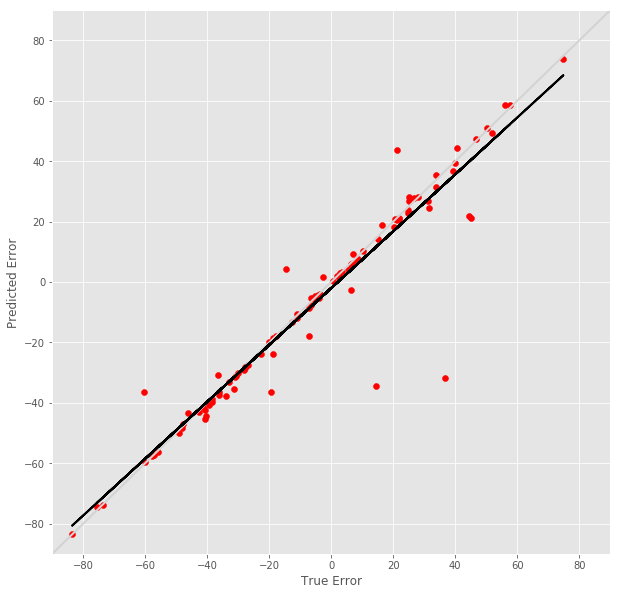

R^2 score for regression on RT: 0.6914
k = 0.8710


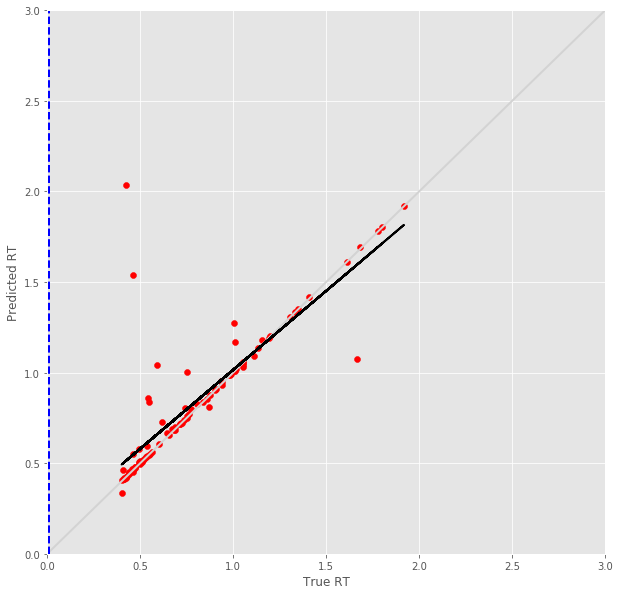

In [19]:
# plot Predicted Response Error and Reaction Time
plt.figure(figsize=(10, 10))
plt.style.use('ggplot')
plt.xlim(-90, 90)
plt.ylim(-90, 90)
plt.scatter(Observed_error, Predicted_error, color = 'r')
plt.xlabel("True Error")  
plt.ylabel("Predicted Error")
xx = numpy.linspace(-90, 90, 1000)
yy = xx
plt.plot(xx, yy, linewidth = 2, color = 'lightgrey')
Observed_error = numpy.array(Observed_error)
reg = LinearRegression().fit(Observed_error.reshape(-1, 1), Predicted_error)
print('R^2 score for regression on Error: %.4f' % (reg.score(Observed_error.reshape(-1, 1), Predicted_error)))
print('k = %.4f' % (reg.coef_))
pred = reg.predict(Observed_error.reshape(-1, 1))
plt.plot(Observed_error, pred, linewidth = 2, color = 'k')
plt.show()

plt.figure(figsize=(10, 10))
plt.style.use('ggplot')
plt.xlim(0, tmax)
plt.ylim(0, tmax)
plt.scatter(RT0_p, RT_p, color = 'r')
plt.xlabel("True RT")  
plt.ylabel("Predicted RT")
xx = numpy.linspace(0, tmax, 1000)
yy = xx
plt.plot(xx, yy, linewidth = 2, color = 'lightgrey')
RT0_p = numpy.array(RT0_p)
reg = LinearRegression().fit(RT0_p.reshape(-1, 1), RT_p)
print('R^2 score for regression on RT: %.4f' % (reg.score(RT0_p.reshape(-1, 1), RT_p)))
print('k = %.4f' % (reg.coef_))
pred = reg.predict(RT0_p.reshape(-1, 1))
plt.plot(RT0_p, pred, linewidth = 2, color = 'k')
plt.axvline((look_back - 1) * h, linestyle="dashed", linewidth = 2, color='b')
plt.show()
